## Finding the optimal layer depth in GCN for best performance.

In [26]:
# load dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import random
import os.path as osp

import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm
from dataclasses import dataclass
from collections import defaultdict

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Load Dataset

In [27]:
# Load Karate Club Graph
karate_graph = nx.karate_club_graph()
karate_num_node = karate_graph.number_of_nodes()
karate_feat = torch.eye(karate_num_node, dtype=torch.float32)
karate_adj = torch.from_numpy(nx.to_numpy_array(karate_graph, weight=None)).type(torch.float32)
LABEL_ENCODE = {"Mr. Hi": 0, "Officer": 1}
karate_label = torch.tensor([LABEL_ENCODE[info['club']] for _, info in karate_graph.nodes.data()])

# Upload Cora dataset
if not osp.exists("Cora"):
    from google.colab import files
    f = files.upload()
    !unzip Cora.zip

# Preprocess Cora
cora_edge = torch.load("./Cora/edge.pt")
cora_edge = torch.transpose(cora_edge, 0, 1)
cora_feat = torch.load("./Cora/feat.pt").type(torch.float32)
cora_label = torch.load("./Cora/label.pt")

cora_num_node = cora_feat.shape[0]
cora_adj = torch.zeros((cora_num_node, cora_num_node))
cora_adj[cora_edge[:, 0], cora_edge[:, 1]] = 1

In [28]:
@dataclass
class Graph:
    name: str
    num_node: int
    adj: torch.Tensor
    feat: torch.Tensor
    label: torch.Tensor
    neighbor: defaultdict[int, list[set[int]]]
    mean_overlap: dict[int, float]
    mean_similarity: dict[int, float]

karate = Graph("karate", karate_num_node, karate_adj, karate_feat, karate_label, defaultdict(list), dict(), dict())
cora = Graph("cora", cora_num_node, cora_adj, cora_feat, cora_label, defaultdict(list), dict(), dict())
datasets = [karate, cora]

## Define GCN Model

In [29]:
class GCNLayer(nn.Module):

    def __init__(self, dim_in: int, dim_out: int):
        super(GCNLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.act = nn.ReLU()
        self.weight = nn.Parameter(data=torch.zeros((dim_in, dim_out), device=device), requires_grad=False)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, feat: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        
        num_node = feat.shape[0]
        adj_eye = adj + torch.eye(num_node, device=device)
        degree = torch.sum(adj_eye, dim=1)
        dgr_inv = torch.diag(1/degree)
        
        out = self.act(dgr_inv @ adj_eye @ feat @ self.weight)
        return out


class GCN(nn.Module):

    def __init__(self, num_layers: int,
                 dim_in: int,
                 dim_hidden: int,
                 dim_out: int):

        super(GCN, self).__init__()

        self.num_layers = num_layers
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out

        self.layers = nn.ModuleList()
        for l in range(num_layers):
            self.layers.append(GCNLayer(self.dim_in if l == 0 else self.dim_hidden, self.dim_out if l == num_layers-1 else self.dim_hidden))


    def forward(self, feat: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        x_in = feat
        for layer in self.layers:
            x_out = layer(x_in, adj)
            x_in = x_out

        return x_out
    
    def forward_k_layer(self, feat: torch.Tensor, adj: torch.Tensor, k: int) -> torch.Tensor:    
        x_in = feat
        for i, layer in enumerate(self.layers):
            if i >= k:
                break
            x_out = layer(x_in, adj)
            x_in = x_out
            
        return x_out

### Experiment 1

## Compute Neighborhood overlap

In [30]:
# Compute graph 1-hop neighbor 
for graph in datasets:
    for node in range(graph.num_node):
        edge_involve_node = np.where(graph.adj[:, node] == 1)
        graph.neighbor[1].append(set(*edge_involve_node))

In [31]:
def get_k_neighbor(neighbor: dict[int, list[set[int]]], node: int, k: int) -> set[int]:

    assert neighbor[k-1]
    prev_neighbor: set[int] = neighbor[k-1][node]
    k_neighbor: set[int] = set()
    for prev in prev_neighbor:
        k_neighbor.update(neighbor[1][prev])
    return k_neighbor


def get_k_neighbor_list(graph: Graph, k: int) -> None:

    for node in range(graph.num_node):
        graph.neighbor[k].append(get_k_neighbor(graph.neighbor, node, k))

for graph in datasets:
    for k in range(2, 11):
        get_k_neighbor_list(graph, k)

In [32]:
from itertools import combinations


for graph in datasets:
    for k in tqdm(range(1, 11)):

        def mean_overlap(i, j):
            neighbor_i = graph.neighbor[k][i]
            neighbor_j = graph.neighbor[k][j]
            Inter_ij = neighbor_i.intersection(neighbor_j)
            len_union_ij = len(neighbor_i) + len(neighbor_j) - len(Inter_ij)
            return len(Inter_ij) / len_union_ij

        overlap_vec = np.vectorize(mean_overlap)

        node_comb = combinations(range(graph.num_node), 2)
        i, j = np.array(list(node_comb)).T
        graph.mean_overlap[k] = np.mean(overlap_vec(i, j))


100%|██████████| 10/10 [09:17<00:00, 55.80s/it]


In [33]:
def measure_node_smoothness(features: np.ndarray) -> np.ndarray:
    
    def compute_sim(i, j):
        x, y = features[i, :], features[j, :]
        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
        
    compute_sim_vec = np.vectorize(compute_sim)
    
    n = features.shape[0]
    node_comb = combinations(range(n), 2)
    i, j = np.array(list(node_comb)).T
    similarities = compute_sim_vec(i, j)
    mean_score = np.mean(np.abs(similarities))
    return mean_score

In [35]:
LAYERS = list(range(1, 11))

for graph in datasets:
    
    graph.adj = graph.adj.to(device)
    
    feat_dim = graph.feat.shape[1]
    model = GCN(max(LAYERS), feat_dim, feat_dim//2, feat_dim//2)
    model.eval()
    
    for k in tqdm(LAYERS):
        feature_vectors = model.forward_k_layer(graph.feat.to(device), graph.adj.to(device), k)
        mean_similarity = measure_node_smoothness(feature_vectors.cpu().numpy())
        graph.mean_similarity[k] = mean_similarity

100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


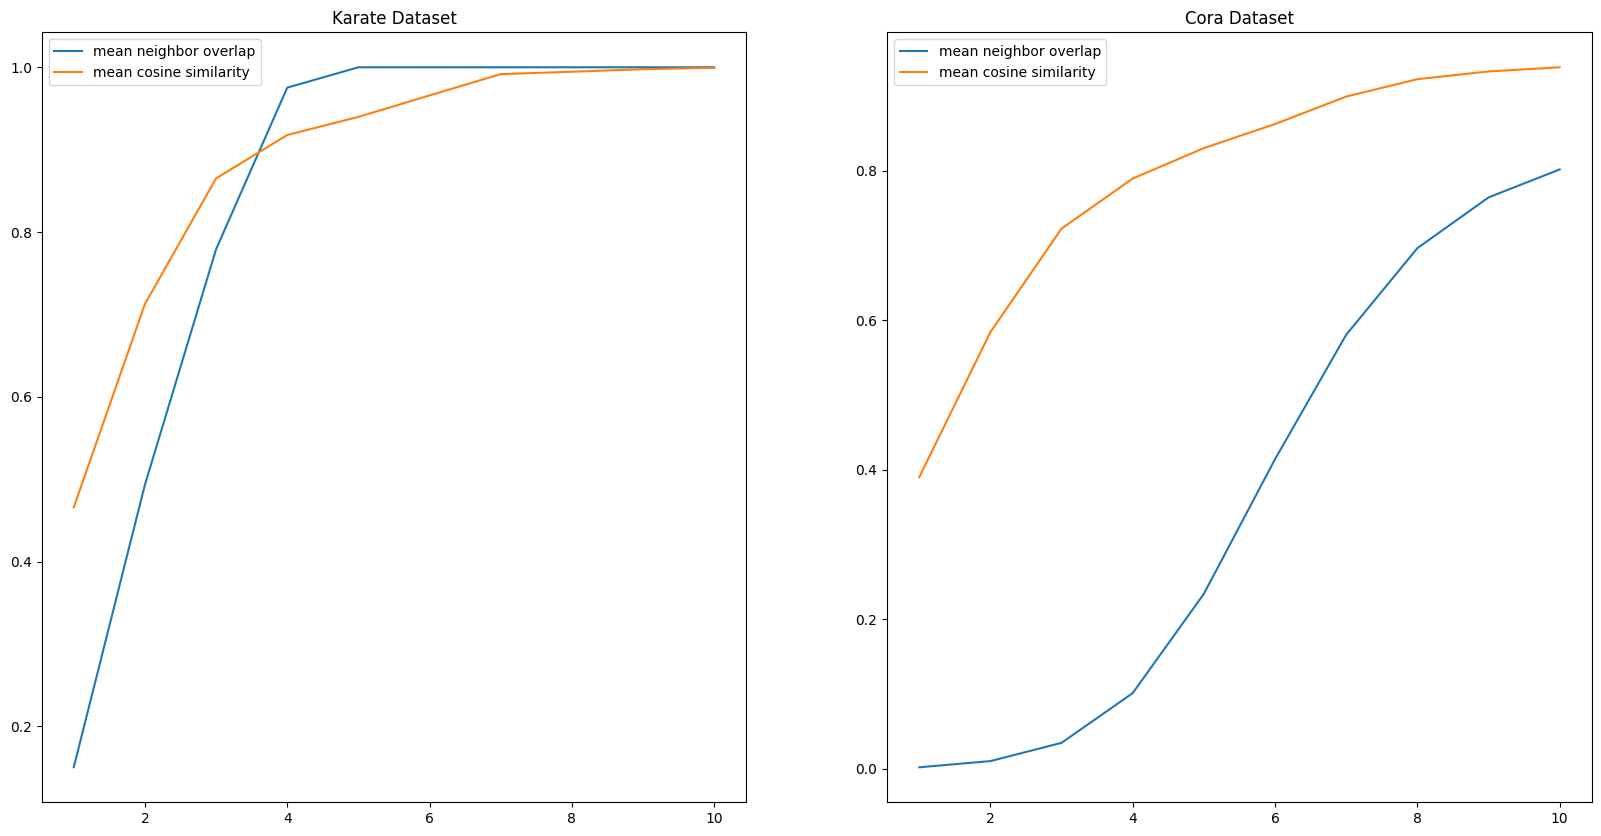

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].set_title("Karate Dataset")
axes[0].plot(LAYERS, karate.mean_overlap.values(), label="mean neighbor overlap")
axes[0].plot(LAYERS, karate.mean_similarity. values(), label="mean cosine similarity")
axes[0].legend()

axes[1].set_title("Cora Dataset")
axes[1].plot(LAYERS, cora.mean_overlap.values(), label="mean neighbor overlap")
axes[1].plot(LAYERS, cora.mean_similarity.values(), label="mean cosine similarity")
axes[1].legend()

## Exp 2

In [37]:
def get_erdos_network(N: int, density: float) -> nx.Graph:
    edge_num = int(N*(N-1)/2 * density)
    graph = nx.gnm_random_graph(N, edge_num, SEED)
    return graph

def get_k_neighbor_list(G: nx.Graph, k: int) -> None:
    return [set(nx.ego_graph(G, node, k)) for node in G.nodes]

def measure_neighbor_overlap(G: nx.Graph, k: int):
    neighbor_list = np.array(get_k_neighbor_list(G, k))
    num_node = len(neighbor_list)

    def overlap(i, j) : # NODE i & NODE j
        neighbor_i: set = neighbor_list[i]
        neighbor_j: set = neighbor_list[j]
        Inter_ij = neighbor_i.intersection(neighbor_j)
        len_union_ij = len(neighbor_i) + len(neighbor_j) - len(Inter_ij)
        return len(Inter_ij) / len_union_ij

    overlap_vec = np.vectorize(overlap)

    node_comb = combinations(range(num_node), 2)
    i, j = np.array(list(node_comb)).T
    overlap_scores = overlap_vec(i, j)
    return np.mean(overlap_scores)

In [38]:
def get_score(N, density, layers):
    graph = get_erdos_network(N, density)
    scoring = defaultdict(list)

    for k in tqdm(layers):
        neighbor_overlap = measure_neighbor_overlap(graph, k)
        model = GCN(k, N, N//2, N//2)
        embedding = torch.eye(N, device=device)
        adj: torch.Tensor = torch.from_numpy(nx.adjacency_matrix(graph).toarray()).to(device)
        feature = model(embedding, adj).cpu()
        smoothness = measure_node_smoothness(feature)
        scoring["overlap"].append(neighbor_overlap)
        scoring["smoothness"].append(smoothness)
    return scoring


100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


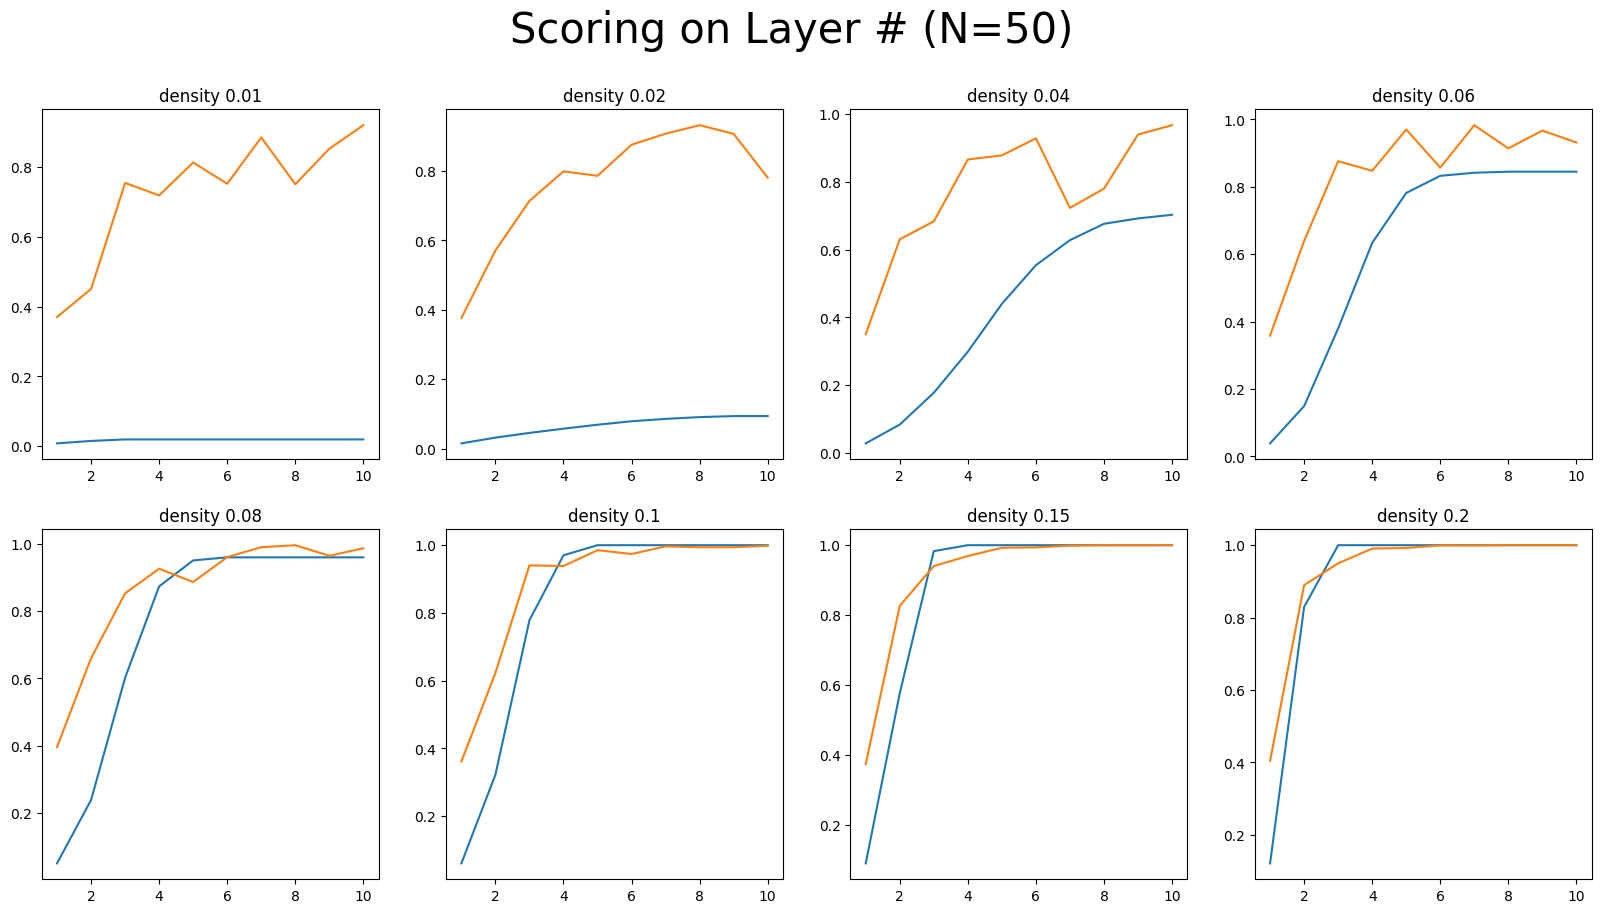

100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


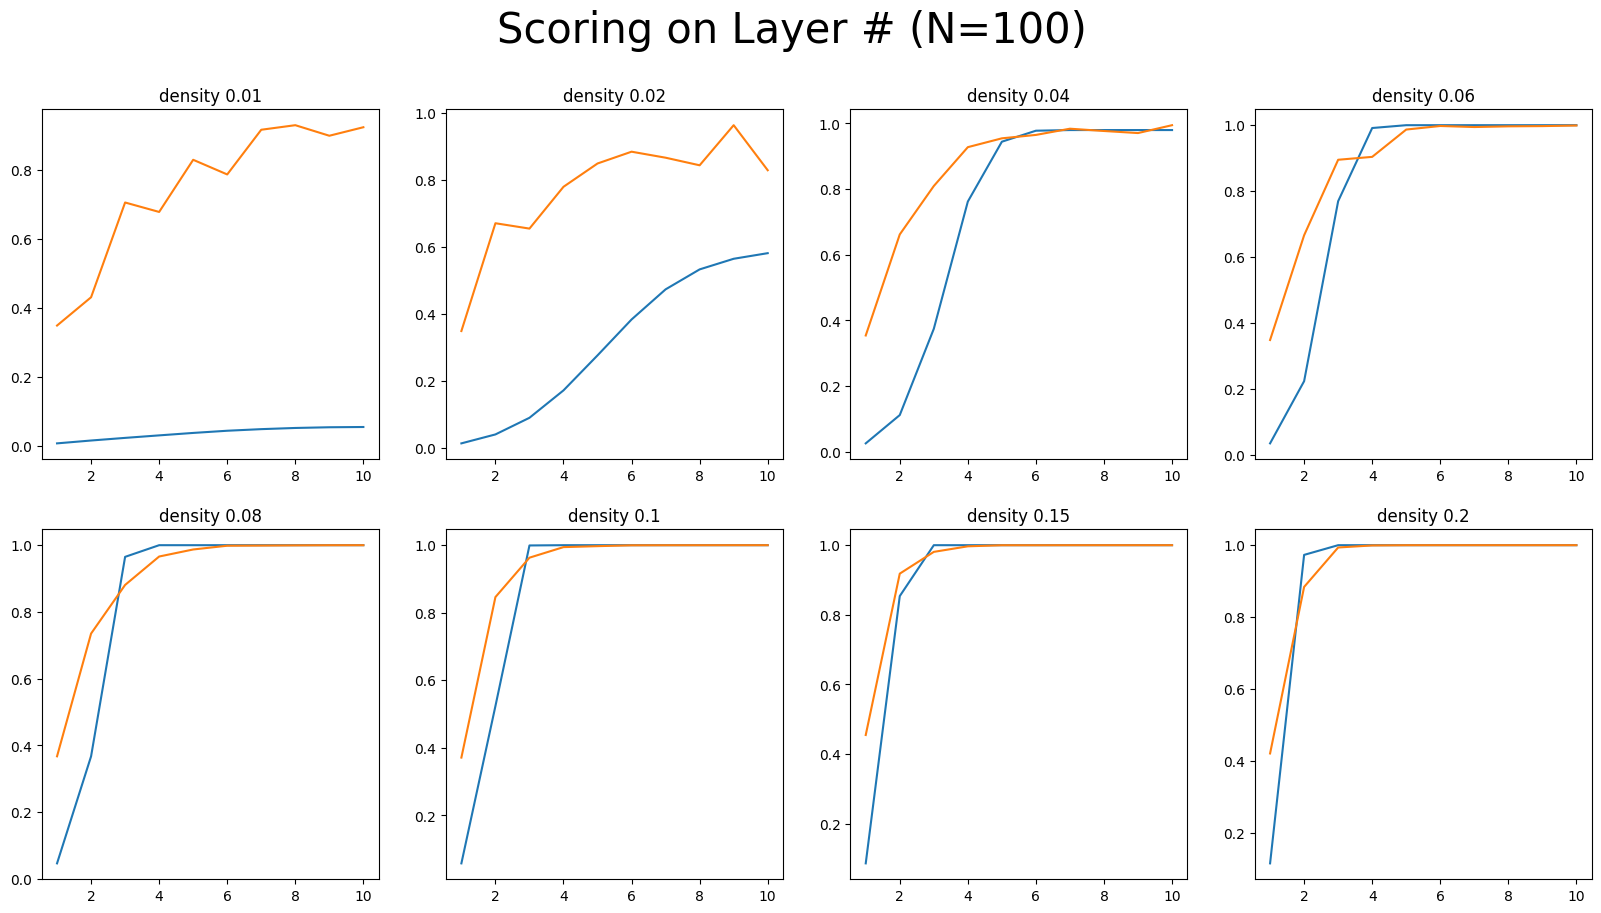

100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


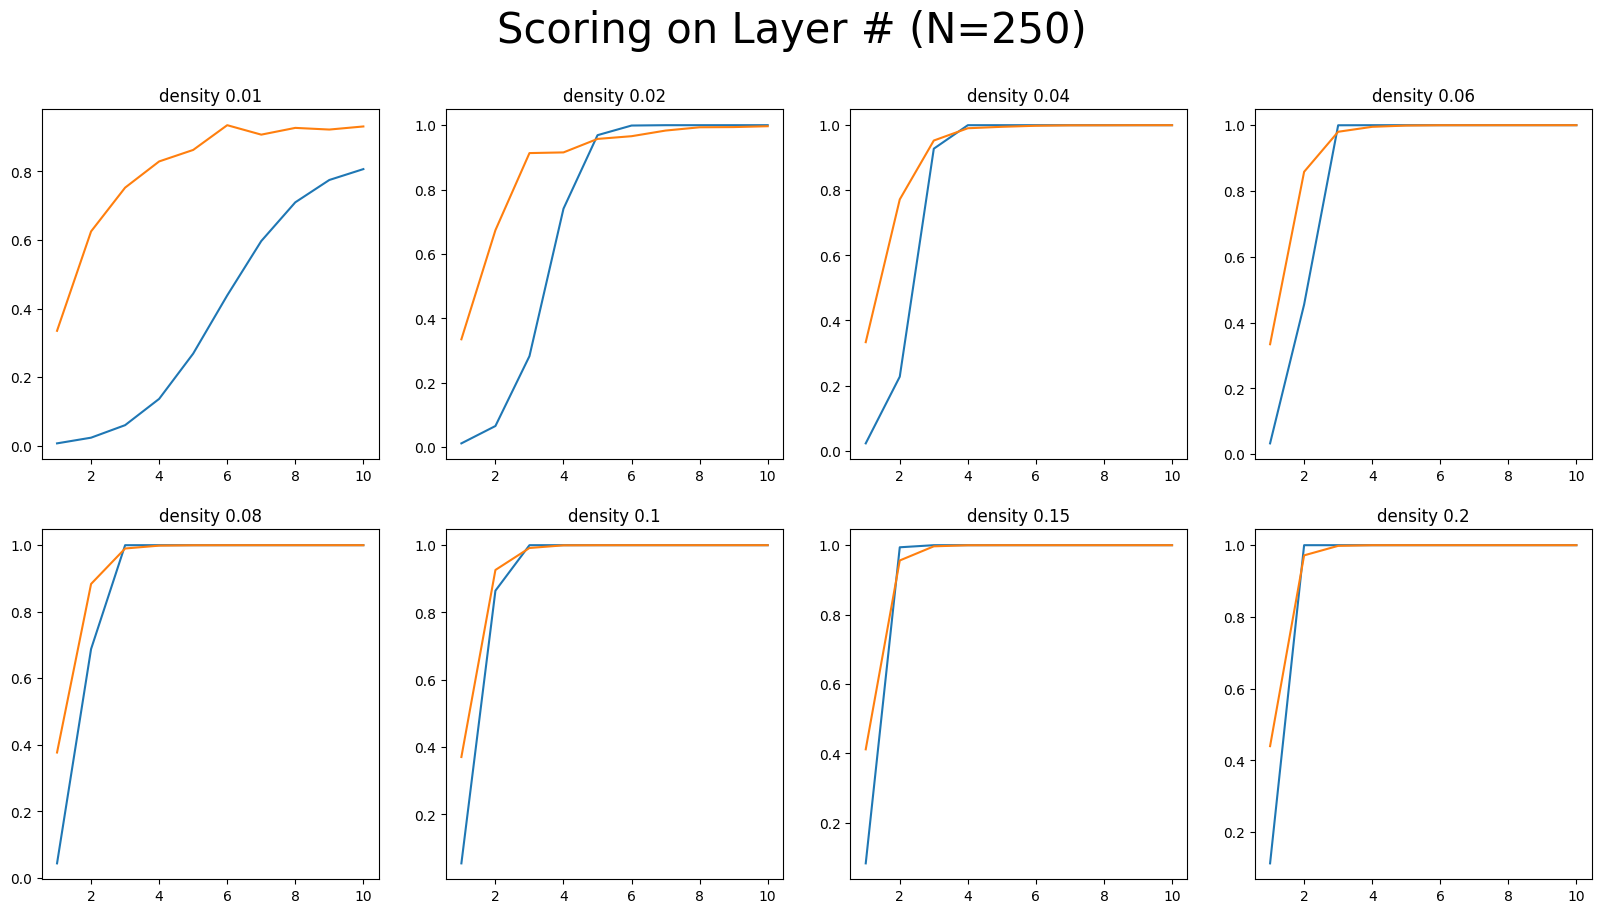

In [39]:
N_list = [50, 100, 250, 500]
dense_list = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2]
LAYERS = list(range(1, 11))

for N in N_list:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    plt.suptitle(f"Scoring on Layer # (N={N})", fontsize = 30)
    for i, dense in enumerate(dense_list):
        ax = axes[divmod(i, 4)]
        scoring = get_score(N, dense, LAYERS)
        ax.set_title(f"density {dense}")
        overlap = ax.plot(LAYERS, scoring["overlap"], label="overlap")
        smooth = ax.plot(LAYERS, scoring["smoothness"], label="smoothness")
    plt.savefig(f"node {N}.png")
    plt.show()



## Exp 3

100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


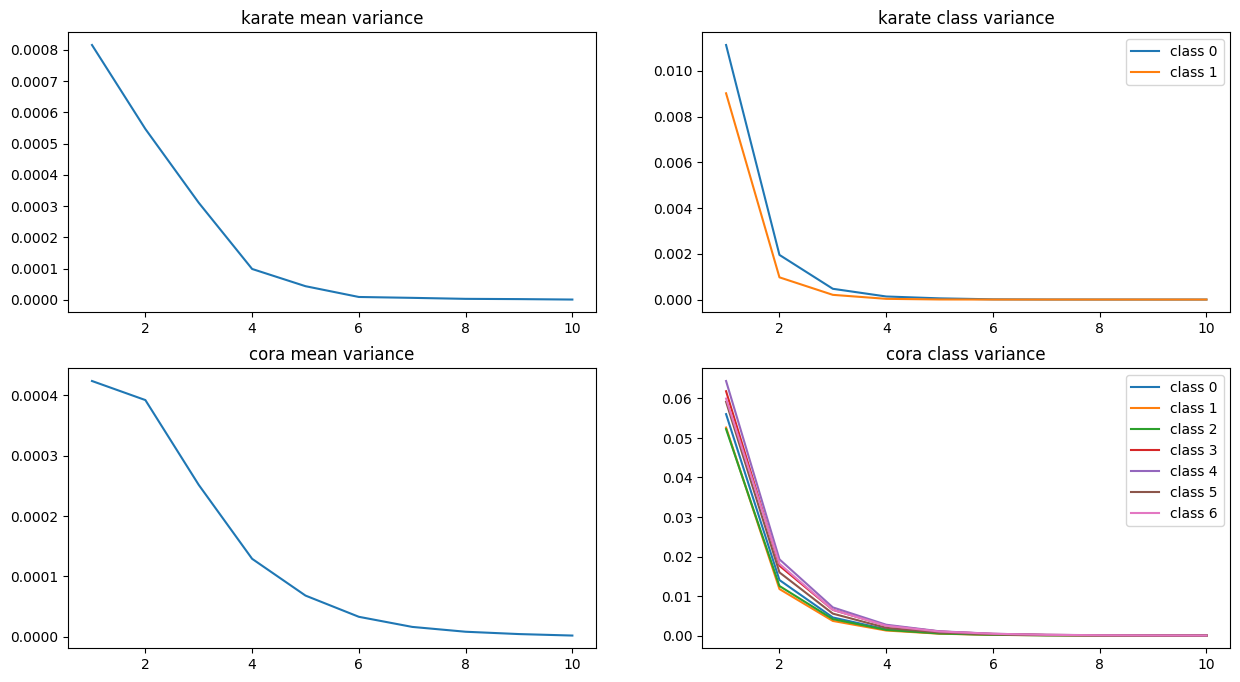

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

for i, graph in enumerate(datasets):
    
    feat_dim = graph.feat.shape[1]
    label_num = max(graph.label)+1
    model = GCN(max(LAYERS), feat_dim, feat_dim//2, feat_dim//2)
    
    mean_variance = []
    class_variance = defaultdict(list)
    
    for num_layer in tqdm(LAYERS):

        feature_matrix = model.forward_k_layer(graph.feat.to(device), graph.adj.to(device), num_layer)
        embedding = feature_matrix
        
        mean_vec = torch.stack([torch.mean(embedding[graph.label == l], axis=0) for l in range(label_num)])
        mean_variance.append(torch.norm(torch.var(mean_vec), p=2).item())
        
        for l in range(0, 7):
            class_variance[l].append(torch.norm(torch.var(embedding[graph.label == l], axis=0), p=2).item())
    
    axes[i, 0].set_title(f"{graph.name} mean variance")
    axes[i, 0].plot(LAYERS, mean_variance)
    axes[i, 1].set_title(f"{graph.name} class variance")
    for l in range(label_num):
        axes[i, 1].plot(LAYERS, class_variance[l], label=f"class {l}")
    axes[i, 1].legend()

plt.show()